In [2]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import random
import os

## 파라미터 설정

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 맥 mps 설정
# device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
# print(f"현재 디바이스는 {device} 입니다.")

In [129]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':5,
    'SEED':41,
    'pth_name':"./git_ignore/pthfile/10X_e30.pth"
}

In [6]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [7]:
path_list = sorted(glob.glob("git_ignore/PDA_mask_img/10X/**/*.png"))
path_list[:10]

['git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=10878,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=10878,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=11785,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=11785,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=13598,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=13598,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=7252,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=7252,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=8159,w=1036,h=1036]-labelled.png',
 'gi

In [8]:
mask_path = path_list[0::2]
mask_path[:10]

['git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=10878,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=11785,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=13598,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=7252,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=8159,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=9065,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=9972,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=11785,y=10878,w=1036,h=1036]-labelled.png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=11785,y=6346,

In [9]:
img_path = path_list[1::2]
img_path[:10]

['git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=10878,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=11785,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=13598,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=7252,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=8159,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=9065,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=10878,y=9972,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=11785,y=10878,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00017-22 [d=2.02347,x=11785,y=6346,w=1036,h=1036].png',
 'git_ignore/PDA_mask_img/10X\\C3L-00017-22\\C3L-00

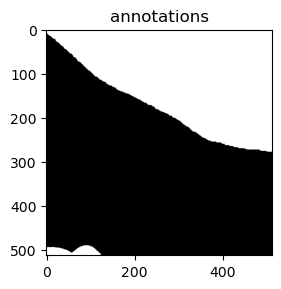

In [10]:
annotation = Image.open(mask_path[0])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

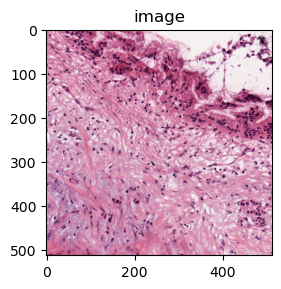

In [11]:
image = Image.open(img_path[0])
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [12]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, train = True, img_transform = None, mask_transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        # 학습용 or 평가용
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.img_transform = img_transform
        self.mask_transform = mask_transform


    def __len__(self):
        if self.train:
            return len(self.X_train) # 학습용 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.train:  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            X_train = self.img_transform(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.mask_transform(Y_train)

            return X_train, Y_train
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.img_transform(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.mask_transform(Y_test)

            return X_test, Y_test

In [13]:
# U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # U-Net의 인코더에 사용되는 은닉층
        # 기본 블록
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        # 디코더에 사용되는 은닉층
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride = 2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding = 1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding = 1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride = 2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride = 2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size = 3, padding = 1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride = 2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        # 합성곱과 업샘플링층의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
        
        x = self.upsample4(x)
        # 인코더의 출력과 업샘플링된 이미지를 합침
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)

        return x

## 데이터 불러오기

In [14]:
mask_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])

# 학습용 데이터
train_set = CustomDataset(img_path = img_path,
                 mask_path = mask_path,
                 mask_transform = mask_transform,
                 img_transform = mask_transform)


In [15]:
imgs = [item[0] for item in train_set]
imgs = torch.stack(imgs, dim=0).numpy()

# 데이터 정규화를 위한 평균값
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

# 데이터 정규화를 위한 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

img_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=(mean_r,mean_g,mean_b), std = (std_r,std_g,std_b)),
                      RandomHorizontalFlip()])

0.8306502 0.6664843 0.76154405
0.14280744 0.20641515 0.15093818


In [16]:
# 학습용 데이터
train_set = CustomDataset(img_path = img_path,
                          mask_path = mask_path,
                          mask_transform = mask_transform,
                          img_transform=img_transform)
# 평가용 데이터
test_set = CustomDataset(img_path = img_path,
                         mask_path=mask_path,
                         mask_transform = mask_transform,
                         img_transform=mask_transform,
                         train=False)

In [17]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
test_loader = DataLoader(test_set)

In [18]:
print(len(train_set),len(test_set))

282 71


In [19]:
print(len(train_loader),len(test_loader))

57 71


## 학습

In [20]:
model = UNet().to(device)

optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

In [20]:
for epoch in range(CFG["EPOCHS"]):

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        
        label = torch.squeeze(label)
        loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()
    print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), CFG["pth_name"])

  0%|          | 0/57 [00:00<?, ?it/s]

epoch1 loss:0.005222644191235304


  0%|          | 0/57 [00:00<?, ?it/s]

epoch2 loss:0.014632023870944977


  0%|          | 0/57 [00:00<?, ?it/s]

epoch3 loss:0.012680690735578537


  0%|          | 0/57 [00:00<?, ?it/s]

epoch4 loss:0.011617627926170826


  0%|          | 0/57 [00:00<?, ?it/s]

epoch5 loss:0.006202262360602617


  0%|          | 0/57 [00:00<?, ?it/s]

epoch6 loss:0.00462908111512661


  0%|          | 0/57 [00:00<?, ?it/s]

epoch7 loss:0.014766864478588104


  0%|          | 0/57 [00:00<?, ?it/s]

epoch8 loss:0.019805144518613815


  0%|          | 0/57 [00:00<?, ?it/s]

epoch9 loss:0.0037995276506990194


  0%|          | 0/57 [00:00<?, ?it/s]

epoch10 loss:0.011983237229287624


  0%|          | 0/57 [00:00<?, ?it/s]

epoch11 loss:0.019573042169213295


  0%|          | 0/57 [00:00<?, ?it/s]

epoch12 loss:0.023128053173422813


  0%|          | 0/57 [00:00<?, ?it/s]

epoch13 loss:0.007906761020421982


  0%|          | 0/57 [00:00<?, ?it/s]

epoch14 loss:0.0024450616911053658


  0%|          | 0/57 [00:00<?, ?it/s]

epoch15 loss:0.003646122757345438


  0%|          | 0/57 [00:00<?, ?it/s]

epoch16 loss:0.008378618396818638


  0%|          | 0/57 [00:00<?, ?it/s]

epoch17 loss:0.0033165256027132273


  0%|          | 0/57 [00:00<?, ?it/s]

epoch18 loss:0.010531753301620483


  0%|          | 0/57 [00:00<?, ?it/s]

epoch19 loss:0.02344347909092903


  0%|          | 0/57 [00:00<?, ?it/s]

epoch20 loss:0.001854957197792828


  0%|          | 0/57 [00:00<?, ?it/s]

epoch21 loss:0.0032402733340859413


  0%|          | 0/57 [00:00<?, ?it/s]

epoch22 loss:0.018298938870429993


  0%|          | 0/57 [00:00<?, ?it/s]

epoch23 loss:0.0038517846260219812


  0%|          | 0/57 [00:00<?, ?it/s]

epoch24 loss:0.003971162252128124


  0%|          | 0/57 [00:00<?, ?it/s]

epoch25 loss:0.015900693833827972


  0%|          | 0/57 [00:00<?, ?it/s]

epoch26 loss:0.013347044587135315


  0%|          | 0/57 [00:00<?, ?it/s]

epoch27 loss:0.004511493723839521


  0%|          | 0/57 [00:00<?, ?it/s]

epoch28 loss:0.009584086947143078


  0%|          | 0/57 [00:00<?, ?it/s]

epoch29 loss:0.007374658714979887


  0%|          | 0/57 [00:00<?, ?it/s]

epoch30 loss:0.014312507584691048


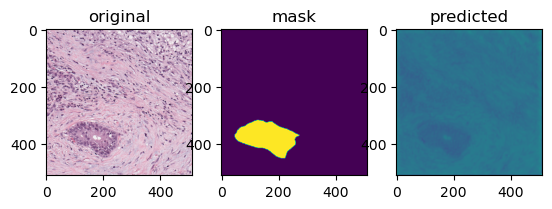

In [130]:
model.load_state_dict(torch.load(CFG["pth_name"], map_location=device))
data, label = test_set[36]
pred = model(torch.unsqueeze(data, dim=0).to(device))
pred = pred.to("cpu")
label = torch.squeeze(label)
with torch.no_grad():
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(data))
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.imshow(pred)

    plt.show()